In [2]:
os.getcwd()

'/Users/lalitayang/Documents/K2/Unit 4/Project'

# Home Credit Default Risk - Exploratory Data Analysis

This notebook is to explore the data provided by Home Credit. The data will be used to predict whether or not an applicant will have difficulty repaying their loan or not. 

The first dataset we are exploring is: application_{train|test}.csv

Description is pulled from the Kaggle competition https://www.kaggle.com/c/home-credit-default-risk

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

In [3]:
def load_credit_data(filename, path='/Users/lalitayang/Documents/K2/Unit 4/Project/data/'):
    """ import data provided by Kaggle"""
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

In [4]:
train = load_credit_data('application_train.csv')
test = load_credit_data('application_test.csv')

In [5]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train.info() 

#note how many column types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


Excluding the contract ID and the target variable, we have 120 features in the application data, of which 16 are categorical. Home Credit provides a document with the descriptions for the columns in the various datasets. Additionally, we have a little over 300k instances in our training data.

Now I want to explore the categorical variables more because I know that I will have to encode the categorical values in order for the machine learning models to work. 

In [7]:
categories = train.select_dtypes(exclude=['int', 'float64']).columns.tolist()
categories #16 categorical features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [8]:
def get_category_types(df):
    cats = df.select_dtypes(exclude=['int', 'float64']).columns.tolist()
    return pd.DataFrame({'cat_feature':cats, 'cat_count':[df[c].nunique() for c in cats]})
        

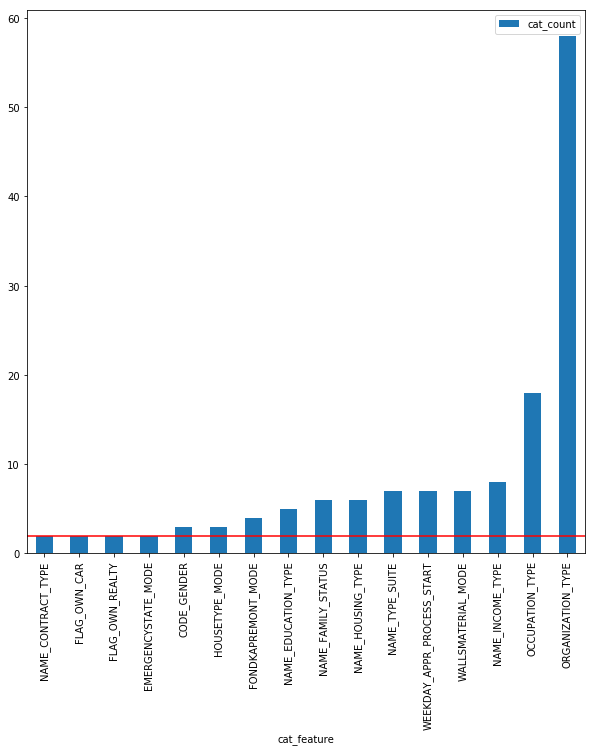

In [9]:
t = get_category_types(train)
ax=t.sort_values(by='cat_count').plot(kind='bar', x='cat_feature', y='cat_count', figsize=(10,10))
ax.axhline(y=2, color='red')
plt.show()

The above visual tells me the cardinality of the categorical variables. Since the feature space is not too large, One Hot Encoding for all the variables would be the easiest and would provide more accurate results since none of the variables have ordinal values. If there were variables with ordinal values, then Label Encoding would be more appropriate. Also if there were more variables that only had 2 unique values, then Label Encoding would keep the feature space smaller and reduce memory consumption. 

I noticed that `CODE_GENDER` had 3 values, so I explored its values and identified that one of the values is "XNA", which likely stands for unavailable.

In [10]:
for c in categories:
    print(train[c].value_counts())
    print("-"*50)

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64
--------------------------------------------------
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
--------------------------------------------------
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64
--------------------------------------------------
Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
--------------------------------------------------
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64
--------------------------------------------------
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave             

Next, I looked at the distribution of the target values and determined that it's unbalanced with only 8% of the total training data noted as 1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments. I will need to remember this for certain models if they perform better with scaled targets.

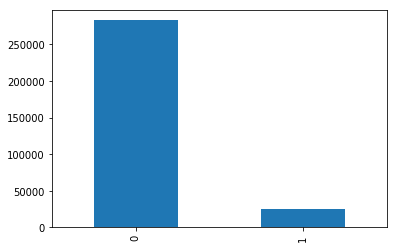

In [11]:
train['TARGET'].value_counts().plot(kind='bar') #skewed targets

In [12]:
target = pd.DataFrame(train['TARGET'].value_counts())
target2 = target.apply(lambda x: x/target.sum(), axis=1).rename(columns={'TARGET':'Percent'})
target = pd.concat([target, target2], axis=1)
target

,TARGET,Percent
0,282686,0.919271
1,24825,0.080729


In [13]:
train_corr = train.corr()
train_corr['TARGET'].sort_values(ascending=False)
# identify which variables right off the bat are most correlated

TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
OWN_CAR_AGE                    0.037612
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
FLAG_WORK_PHONE                0.028524
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
CNT_CHILDREN                   0.019187
CNT_FAM_MEMBERS                0.009308
OBS_30_CNT_SOCIAL_CIRCLE       0.009131
OBS_60_CNT_SOCIAL_CIRCLE       0.009022
REG_REGION_NOT_WORK_REGION     0.006942
REG_REGION_NOT_LIVE_REGION     0.005576
FLAG_DOCUMENT_2                0.005417
FLAG_DOCUMENT_21               0.003709


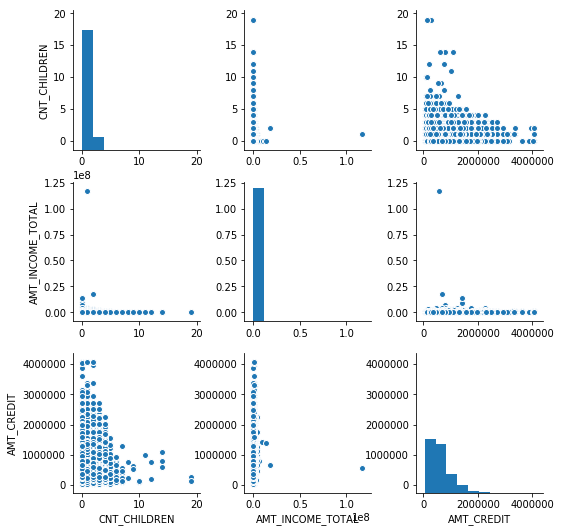

In [14]:
sns.pairplot(train.iloc[:,6:9], dropna=True)

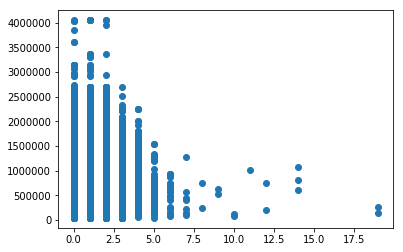

In [15]:
plt.scatter(train['CNT_CHILDREN'], train['AMT_CREDIT'])

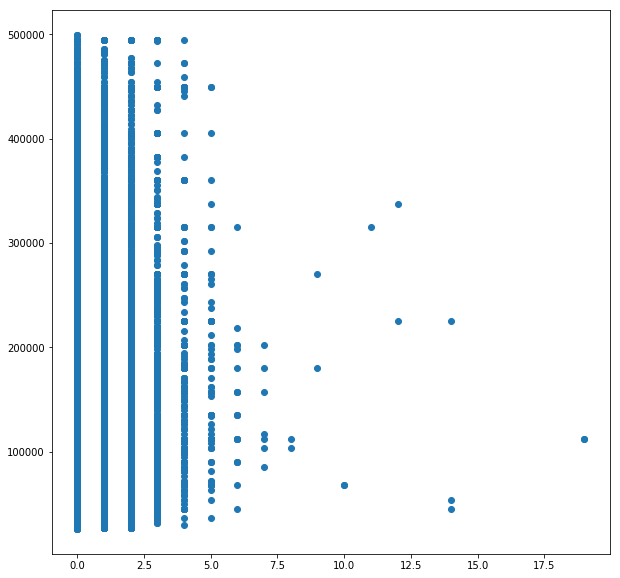

In [16]:
filtered = train[train['AMT_INCOME_TOTAL'] < 500000]
plt.figure(figsize=(10,10))
plt.scatter(filtered['CNT_CHILDREN'], filtered['AMT_INCOME_TOTAL'])

In [17]:
numeric = train.iloc[:, 6:10].columns.tolist() + train.iloc[:, 16:20].columns.tolist()
numeric

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION']

In [18]:
sns.set_style('whitegrid')

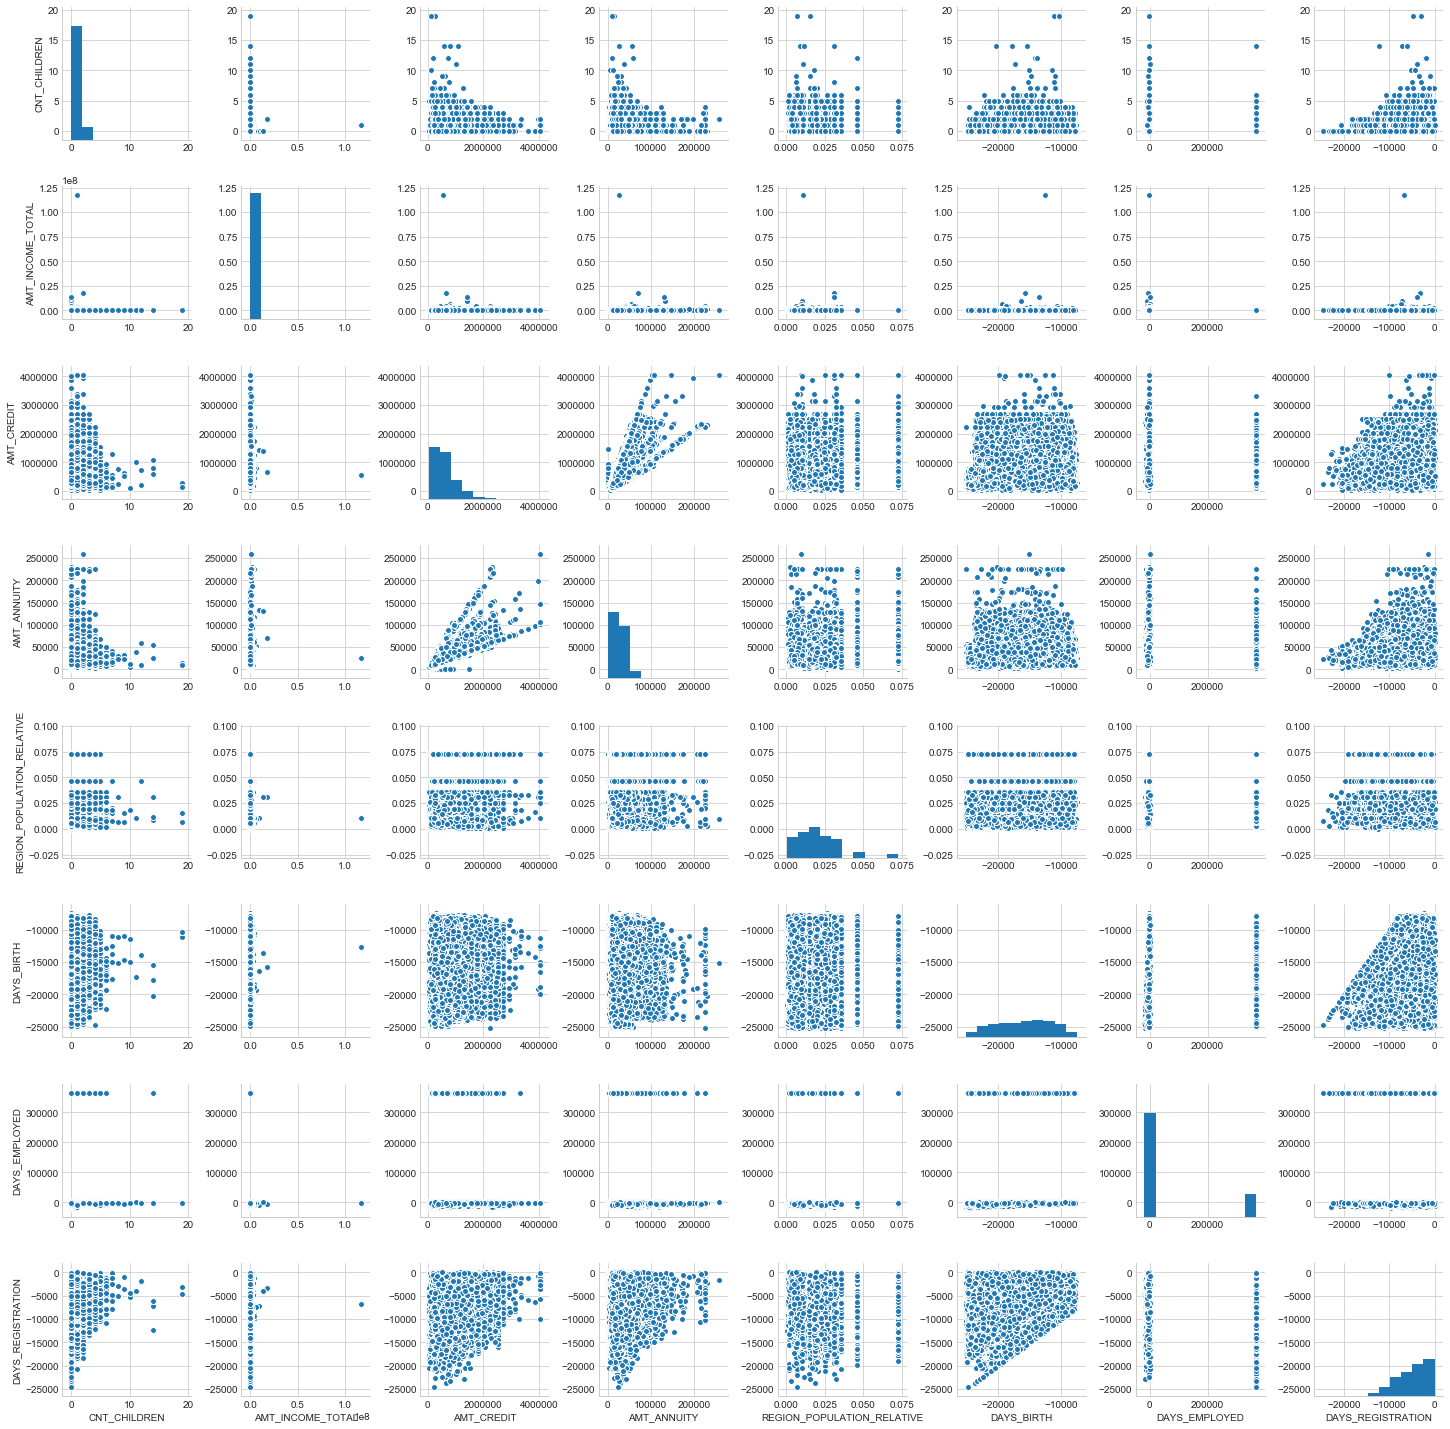

In [19]:
sns.pairplot(train[numeric].fillna(0))

In [20]:
train[numeric].describe()

#someone has 19 children?! 

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION
count,307511.000000,3.075110e+05,3.075110e+05,307499.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.417052,1.687979e+05,5.990260e+05,27108.573909,0.020868,-16036.995067,63815.045904,-4986.120328
std,0.722121,2.371231e+05,4.024908e+05,14493.737315,0.013831,4363.988632,141275.766519,3522.886321
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,-25229.000000,-17912.000000,-24672.000000
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,-19682.000000,-2760.000000,-7479.500000
50%,0.000000,1.471500e+05,5.135310e+05,24903.000000,0.018850,-15750.000000,-1213.000000,-4504.000000
75%,1.000000,2.025000e+05,8.086500e+05,34596.000000,0.028663,-12413.000000,-289.000000,-2010.000000
max,19.000000,1.170000e+08,4.050000e+06,258025.500000,0.072508,-7489.000000,365243.000000,0.000000


In [21]:
train[train['CNT_CHILDREN'] == 19]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
155369,280108,0,Cash loans,F,N,Y,19,112500.0,269550.0,13891.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
265784,407877,0,Cash loans,F,N,Y,19,112500.0,135000.0,8788.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


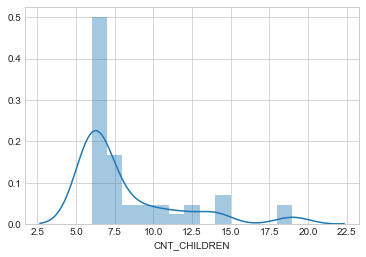

In [22]:
sns.distplot(train[train['CNT_CHILDREN'] > 5]['CNT_CHILDREN'], bins=range(5, 20, 1))

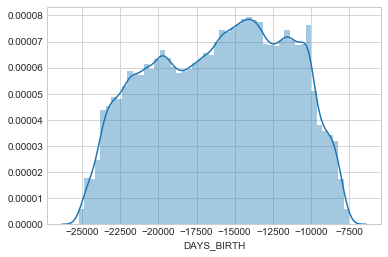

In [23]:
sns.distplot(train['DAYS_BIRTH'])

In [24]:
train['YEARS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x: -x/365)

In [25]:
train['YEARS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: -x/365)

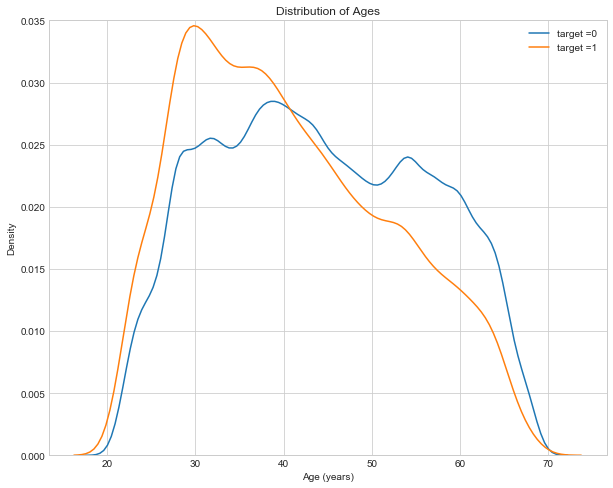

In [26]:
plt.figure(figsize=(10,8))
sns.kdeplot(train.loc[train['TARGET']==0, 'YEARS_BIRTH'], label='target =0')
sns.kdeplot(train.loc[train['TARGET']==1, 'YEARS_BIRTH'], label='target =1')

plt.ylim(0,0.035)
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

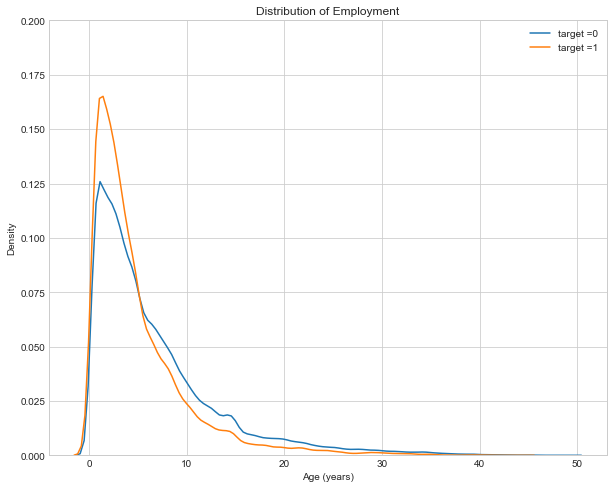

In [31]:
plt.figure(figsize=(10,8))
sns.kdeplot(train.loc[(train['TARGET']==0) & (train['YEARS_EMPLOYED']>-200), 'YEARS_EMPLOYED'], label='target =0')
sns.kdeplot(train.loc[(train['TARGET']==1) & (train['YEARS_EMPLOYED']>-200), 'YEARS_EMPLOYED'], label='target =1')

plt.ylim(0,0.2)
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Employment');

In [30]:
train[['YEARS_BIRTH', 'YEARS_EMPLOYED']].describe()

,YEARS_BIRTH,YEARS_EMPLOYED
count,307511.000000,307511.000000
mean,43.936973,-174.835742
std,11.956133,387.056895
min,20.517808,-1000.665753
25%,34.008219,0.791781
50%,43.150685,3.323288
75%,53.923288,7.561644
max,69.120548,49.073973


In [32]:
train[numeric].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 8 columns):
CNT_CHILDREN                  307511 non-null int64
AMT_INCOME_TOTAL              307511 non-null float64
AMT_CREDIT                    307511 non-null float64
AMT_ANNUITY                   307499 non-null float64
REGION_POPULATION_RELATIVE    307511 non-null float64
DAYS_BIRTH                    307511 non-null int64
DAYS_EMPLOYED                 307511 non-null int64
DAYS_REGISTRATION             307511 non-null float64
dtypes: float64(5), int64(3)
memory usage: 18.8 MB


### Explore columns with nulls and determine whether or not to impute or to remove either the feature

Dropped the features with over 50% missing values. The majority of the features with more than 50% nulls relate to details of the applicant's building where they live and would intuitively unlikely impact the model very much,

In [33]:
def calc_nulls(df, percentage=0.0):
    """ returns: dataframe of features with null values and shape
        null count
        percentage: specify % to get features that containing % greater
    """
    nulls = df.isnull().sum().to_frame().reset_index()
    nulls.columns = ['columns', 'null_count']
    nulls['percent'] = nulls['null_count'].apply(lambda x: x/df.shape[0])
    nulls = nulls[nulls['null_count'] >0] # add percentage of missing. if~50% missing then maybe drop?
    nulls = nulls[nulls['percent'] > percentage]
    print(nulls.shape)
    return nulls

In [34]:
nulls = calc_nulls(train, 0.5)
nulls

(41, 3)


,columns,null_count,percent
21,OWN_CAR_AGE,202929,0.659908
41,EXT_SOURCE_1,173378,0.563811
44,APARTMENTS_AVG,156061,0.507497
45,BASEMENTAREA_AVG,179943,0.585160
47,YEARS_BUILD_AVG,204488,0.664978
48,COMMONAREA_AVG,214865,0.698723
49,ELEVATORS_AVG,163891,0.532960
50,ENTRANCES_AVG,154828,0.503488
52,FLOORSMIN_AVG,208642,0.678486
53,LANDAREA_AVG,182590,0.593767


In [35]:
drop_null_vars = list(nulls[nulls['percent'] > 0.5]['columns']) #drop features with >50% null
drop_null_vars.append('EMERGENCYSTATE_MODE') #less than 50% missing but uninterpretable/difficulty to impute
drop_null_vars

['OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [36]:
len(drop_null_vars)

42

#### Category/text preprocessing

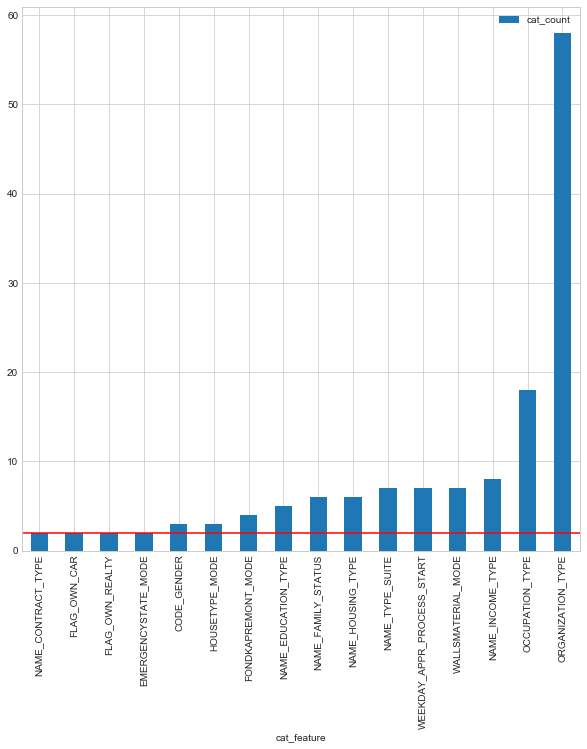

In [37]:
# remaining categorical features
t = get_category_types(train)
ax=t.sort_values(by='cat_count').plot(kind='bar', x='cat_feature', y='cat_count', figsize=(10,10))
ax.axhline(y=2, color='red')
plt.show()

In [38]:
train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [39]:
text_cols = train.select_dtypes(exclude=[int, float]).columns
text_feats = [e for e in text_cols if e not in drop_null_vars]
text_feats

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [40]:
def prep_text_cols(df, text_cols=text_cols):
    df[text_cols].fillna('Blank', inplace=True)
    ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
    df_ohe = ohe.fit_transform(df[text_cols])
    df.drop(text_cols, inplace=True, axis=1)
    df = pd.concat([df, df_ohe], axis=1)
    return df

## Numericals Impute

In [41]:
train[calc_nulls(train)['columns']].describe().T

(67, 3)


,count,mean,std,min,25%,50%,75%,max
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
OWN_CAR_AGE,104582.0,12.061091,11.944812,0.000000e+00,5.000000,9.000000,15.000000,9.100000e+01
CNT_FAM_MEMBERS,307509.0,2.152665,0.910682,1.000000e+00,2.000000,2.000000,3.000000,2.000000e+01
EXT_SOURCE_1,134133.0,0.502130,0.211062,1.456813e-02,0.334007,0.505998,0.675053,9.626928e-01
EXT_SOURCE_2,306851.0,0.514393,0.191060,8.173617e-08,0.392457,0.565961,0.663617,8.549997e-01
EXT_SOURCE_3,246546.0,0.510853,0.194844,5.272652e-04,0.370650,0.535276,0.669057,8.960095e-01
APARTMENTS_AVG,151450.0,0.117440,0.108240,0.000000e+00,0.057700,0.087600,0.148500,1.000000e+00
BASEMENTAREA_AVG,127568.0,0.088442,0.082438,0.000000e+00,0.044200,0.076300,0.112200,1.000000e+00
YEARS_BEGINEXPLUATATION_AVG,157504.0,0.977735,0.059223,0.000000e+00,0.976700,0.981600,0.986600,1.000000e+00


Identifiy features where using mean is more intuitive than using median (look at distribution above)

In [42]:
imp_mean_cols = ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE']

# Add new data sources -- Below is INCOMPLETE -- to pick up with time

After calculating a base score, I decided to see if I could increase the accuracy by incorporating more data that had been provided. 

I started with the bureau data that contains an applicants past loans and various information around it. I grouped by each applicant and counted the number of loans each applicant had and the mean, min, and max of the numeric values and merged with the train data

In [43]:
bureau = load_credit_data('bureau.csv')

In [44]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [45]:
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [68]:
bur_loan_count = bureau.groupby(by='SK_ID_CURR').SK_ID_BUREAU.agg('count').reset_index().rename(columns={'SK_ID_BUREAU':'loan_count'})

In [70]:
bur_loan_count.head()

,SK_ID_CURR,loan_count
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [59]:
bur_stats = bureau.drop('SK_ID_BUREAU', axis=1).groupby(by='SK_ID_CURR').agg(['mean', 'min', 'max']).reset_index().apply(lambda x: round(x,2))

In [60]:
bur_stats.columns

MultiIndex(levels=[['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'SK_ID_CURR'], ['mean', 'min', 'max', '']],
           labels=[[12, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11], [3, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]])

In [65]:
bur_names = ['_'.join(c).strip() for c in bur_stats.columns]


In [66]:
bur_stats.columns = bur_names
bur_stats.head()

,SK_ID_CURR_,DAYS_CREDIT_mean,DAYS_CREDIT_min,DAYS_CREDIT_max,CREDIT_DAY_OVERDUE_mean,CREDIT_DAY_OVERDUE_min,CREDIT_DAY_OVERDUE_max,DAYS_CREDIT_ENDDATE_mean,DAYS_CREDIT_ENDDATE_min,DAYS_CREDIT_ENDDATE_max,...,AMT_CREDIT_SUM_LIMIT_max,AMT_CREDIT_SUM_OVERDUE_mean,AMT_CREDIT_SUM_OVERDUE_min,AMT_CREDIT_SUM_OVERDUE_max,DAYS_CREDIT_UPDATE_mean,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_UPDATE_max,AMT_ANNUITY_mean,AMT_ANNUITY_min,AMT_ANNUITY_max
0,100001,-735.00,-1572,-49,0.0,0,0,82.43,-1329.0,1778.0,...,0.00,0.0,0.0,0.0,-93.14,-155,-6,3545.36,0.0,10822.5
1,100002,-874.00,-1437,-103,0.0,0,0,-349.00,-1072.0,780.0,...,31988.56,0.0,0.0,0.0,-499.88,-1185,-7,0.00,0.0,0.0
2,100003,-1400.75,-2586,-606,0.0,0,0,-544.50,-2434.0,1216.0,...,810000.00,0.0,0.0,0.0,-816.00,-2131,-43,NaN,NaN,NaN
3,100004,-867.00,-1326,-408,0.0,0,0,-488.50,-595.0,-382.0,...,0.00,0.0,0.0,0.0,-532.00,-682,-382,NaN,NaN,NaN
4,100005,-190.67,-373,-62,0.0,0,0,439.33,-128.0,1324.0,...,0.00,0.0,0.0,0.0,-54.33,-121,-11,1420.50,0.0,4261.5


In [71]:
bur_prep = pd.merge(bur_loan_count, bur_stats, left_on='SK_ID_CURR', right_on='SK_ID_CURR_').drop('SK_ID_CURR_', axis=1, inplace=True)

In [76]:
bur_prep.head()

,SK_ID_CURR,loan_count,DAYS_CREDIT_mean,DAYS_CREDIT_min,DAYS_CREDIT_max,CREDIT_DAY_OVERDUE_mean,CREDIT_DAY_OVERDUE_min,CREDIT_DAY_OVERDUE_max,DAYS_CREDIT_ENDDATE_mean,DAYS_CREDIT_ENDDATE_min,...,AMT_CREDIT_SUM_LIMIT_max,AMT_CREDIT_SUM_OVERDUE_mean,AMT_CREDIT_SUM_OVERDUE_min,AMT_CREDIT_SUM_OVERDUE_max,DAYS_CREDIT_UPDATE_mean,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_UPDATE_max,AMT_ANNUITY_mean,AMT_ANNUITY_min,AMT_ANNUITY_max
0,100001,7,-735.00,-1572,-49,0.0,0,0,82.43,-1329.0,...,0.00,0.0,0.0,0.0,-93.14,-155,-6,3545.36,0.0,10822.5
1,100002,8,-874.00,-1437,-103,0.0,0,0,-349.00,-1072.0,...,31988.56,0.0,0.0,0.0,-499.88,-1185,-7,0.00,0.0,0.0
2,100003,4,-1400.75,-2586,-606,0.0,0,0,-544.50,-2434.0,...,810000.00,0.0,0.0,0.0,-816.00,-2131,-43,NaN,NaN,NaN
3,100004,2,-867.00,-1326,-408,0.0,0,0,-488.50,-595.0,...,0.00,0.0,0.0,0.0,-532.00,-682,-382,NaN,NaN,NaN
4,100005,3,-190.67,-373,-62,0.0,0,0,439.33,-128.0,...,0.00,0.0,0.0,0.0,-54.33,-121,-11,1420.50,0.0,4261.5


In [82]:
bur_prep.to_csv('bureau_prepped.csv')

In [78]:
train_prep = pd.merge(train, bur_prep, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

In [81]:
train_prep.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_CREDIT_SUM_LIMIT_max,AMT_CREDIT_SUM_OVERDUE_mean,AMT_CREDIT_SUM_OVERDUE_min,AMT_CREDIT_SUM_OVERDUE_max,DAYS_CREDIT_UPDATE_mean,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_UPDATE_max,AMT_ANNUITY_mean,AMT_ANNUITY_min,AMT_ANNUITY_max
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,31988.56,0.0,0.0,0.0,-499.88,-1185.0,-7.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,810000.00,0.0,0.0,0.0,-816.00,-2131.0,-43.0,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.00,0.0,0.0,0.0,-532.00,-682.0,-382.0,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.00,0.0,0.0,0.0,-783.00,-783.0,-783.0,NaN,NaN,NaN
